# TD Methods: SARSA and Q-Learning

In [ ]:
!pip install gymnasium -- deps
!pip install plotly

import gym as gym
import numpy as np
import plotly.express as px # Install with: conda install -c plotly plotly_express

print(f"Gym version: {gym.__version__}")

In [ ]:
# Video management imports
import cv2

# Helper functions to save videos and images
def save_video(img_array, path='/content/drive/test.mp4'):
  height, width, layers = img_array[0].shape
  size = (width, height)
  out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'AVC1'), 15, size)
  for i in range(len(img_array)):
    bgr_img = cv2.cvtColor(img_array[i], cv2.COLOR_RGB2BGR)
    out.write(bgr_img)
  out.release()
  print('Video saved.')

def save_images(img_array, path='./images'):
  for i, image in enumerate(img_array):
    bgr_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path + '/img_' + str(i) + '.jpg', bgr_img)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if we running in Google Colab or Jupyter Notebook
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print('Running in Google Colab')
    # Connect with Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # This auxiliary function simplifies the visualization of OpenCV Images
    from google.colab import output
    def clear_ouput():
        ouput.clear()
else:
    from IPython.display import clear_output
    print('Running in Jupyter Notebook')

Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The Environment: Cliff Walking
(From R. S. Sutton and A. G. Barto, Reinforcement Learning: An Introduction, 2nd ed. Cambridge, MA: The MIT Press, 2018)

![Cliff Walking Grid World](https://miro.medium.com/max/700/1*52MwrYKyzQXuKZ88rqu70A.png)

This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked "The Cliff". Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start.

In this environment, the position of a cell is encoded in the following way:
```
|(0, 0) (0, 1) ... (0, 11)|
|(1, 0) (1, 1) ... (1, 11)|
|(2, 0) (2, 1) ... (2, 11)|
|(3, 0) (3, 1) ... (3, 11)|
```
If we number the cells with consecutively, row-wise, we have:
```
| 0  1 ... 11|
|12 13 ... 23|
|24 25 ... 35|
|36 37 ... 47|
```
Which is the encoding of the observations of the environment.

The observation space is just the number in [0, 47] of the cell where the agent is.

The action space is a value:
- 0: Up
- 1: Right
- 2: Down
- 3: Left

The agent always starts on cell 36 and has to reach the cell 47.

More information: The CliffWalking environment [Gymnasium - CliffWalking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/)

## Base TD Agent

In [ ]:
class TDAgent:
  def __init__(self, /, num_states, num_actions, gamma = 1, alpha = 0.9, epsilon = 0.3):
    # Future discount parameter
    self.gamma = gamma
    # Learning rate
    self.alpha = alpha
    # Epsilon parameter for the e-greedy policy
    self.epsilon = epsilon
    # Number of states
    self.num_states = num_states
    # Number of actions
    self.num_actions = num_actions
    # Q-values
    self.q_values = np.zeros((self.num_states, self.num_actions))

  def choose_policy_action(self, observation):
    """Chooses the action with the maximum q-value.

    Args:
      observation: An observation from the environment.
    Returns:
      The greedy action (the one with best value).
    """
    return self.argmax(self.q_values[observation, :])

  def choose_e_greedy_action(self, observation):
    """Chooses an action following the e-greedy exploration method.

    Args:
      observation: An observation from the environment.
    Returns:
      The e-greedy action. With probability e, it returns a random action, which
      includes the policy action, otherwise, with probability 1 - e, it returns
      the policy action.
    """
    if np.random.rand() < self.epsilon:
      return np.random.choice(range(self.num_actions))
    else:
      return self.choose_policy_action(observation)

  def argmax(self, np_array):
    """argmax method with random tie-breaking.

    Args:
      np_array: A numpy array.
    Returns:
      Index of one of the appearances of the highest value in the array.
    """
    tie_indices = np.flatnonzero(np_array == np_array.max())
    return np.random.choice(tie_indices)

## SARSA Agent

SARSA updates the action-value function Q at each step. The update rule for SARSA is:

$$ Q(S_t, A_t) = Q(S_t, A_t) + \alpha(R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)) $$

Notice that the next observation and action are chosen before the update under the current policy $\pi$.

In [ ]:
class SarsaAgent(TDAgent):
  def step(self, next_observation, next_action, reward, done):
    """Updates the agent's Q-Values.

    The Q-Values are updated using the bellman update
    Q(S_t, A_t) = Q(S_t, A_t) + alpha * [R_t+1 + gamma * Q(S_t+1, A_t+1) - Q(S_t, A_t)]
    """
    # Calculate the SARSA update
    # Which is the value of the TD target for the final state?
    td_target = reward
    if(not done):
      # Which is the value of the TD target for non-ending states?
      # Use self.q_values and the discounting parameter self.gamma
      td_target += self.gamma * self.q_values[next_observation, next_action]
    # The SARSA update using the calculated td_target variable?
    # Hint: You have the current state and action stored in
    # self.observation and self.action. The learning rate is self.alpha.
    self.q_values[self.observation, self.action] += self.alpha * (td_target - self.q_values[self.observation, self.action])

### Training

In [ ]:
# Num of episodes to learn
EPISODES = 5000
# Initialize the environment
env = gym.make('CliffWalking-v0', render_mode='rgb_array')

# Define agent
sarsa_agent = SarsaAgent(num_states=(4 * 12), num_actions= 4, gamma= 1.0, alpha= 0.6, epsilon= 0.1)
# Tracking the training
visit_count = np.zeros(4*12)

for episode in range(EPISODES):
    done = False
    # Get first observation
    sarsa_agent.observation, _ = env.reset()
    visit_count[sarsa_agent.observation] += 1
    # Choose action
    sarsa_agent.action = sarsa_agent.choose_e_greedy_action(sarsa_agent.observation)
    while not done:
        # Take a step in env
        next_observation, reward, terminated, truncated, _ = env.step(sarsa_agent.action)
        done = terminated or truncated

        # Choose next action
        next_action = sarsa_agent.choose_e_greedy_action(next_observation)
        # Have the agent update its Q-Values
        sarsa_agent.step(next_observation, next_action, reward, done)
        # Update agent observation to new one
        sarsa_agent.observation = next_observation
        sarsa_agent.action = next_action
        visit_count[sarsa_agent.observation] += 1

### Training Evolution

In [ ]:
fig = px.imshow(visit_count.reshape((4, 12)))
fig.show()

In [ ]:
print(sarsa_agent.q_values)

[[ -27.58538682  -27.14648841  -28.43492897  -27.76129948]
 [ -23.22388179  -18.36363041  -27.35482117  -27.86426519]
 [ -18.84709296  -14.89750199  -27.06983777  -27.56618688]
 [ -24.526502    -12.27995528  -24.91709302  -22.91963675]
 [ -24.21874401  -10.43087331  -20.32369192  -22.91139373]
 [ -17.22103341   -9.64309151  -18.36279646  -21.41941702]
 [ -16.91505622   -9.08131083  -20.65031788  -19.69422578]
 [ -17.45311376   -7.70877962  -14.89669288  -17.47601975]
 [ -14.36520443   -6.15708575  -17.98298154  -15.18206296]
 [ -12.3469383    -5.00001944  -18.23856777  -16.05430203]
 [  -8.91971079   -4.00000013  -14.67331299  -15.31433821]
 [ -10.23614144  -13.64911984   -3.          -15.23178966]
 [ -28.29620777  -23.26827097  -28.62651579  -27.98085795]
 [ -25.05963404  -26.11449887  -27.45199606  -27.5255764 ]
 [ -18.72685408  -28.13893758  -26.41661013  -28.68335723]
 [ -20.30656742  -38.22312181  -29.93513157  -22.36917576]
 [ -26.36125802  -16.57920975  -31.26942433  -26.6648626

### Testing

In [ ]:
observation, _ = env.reset()
done = False
images = []
while not done:
    action = sarsa_agent.choose_policy_action(observation)
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    image = env.render()
    images.append(image)

    if len(images) > 100:
        done = True

save_video(images, path='video/SARSA.mp4')

Video saved.


## Q-Learning Agent

Q-Learning updates the action-value function Q at each step, as SARSA. The update rule for Q-Learning is:

$$ Q(S_t, A_t) = Q(S_t, A_t) + \alpha(R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a) - Q(S_t, A_t)) $$

In this case, the action used to compute the target is different from the one used for the behavior of the agent.

In [ ]:
class QLearningAgent(TDAgent):
    def step(self, next_observation, reward, done):
        """Updates the agent's Q-Values.

        The Q-Values are updated using the bellman update
        Q(S_t, A_t) = Q(S_t, A_t) + alpha * [R_t+1 + gamma * max_a(Q(S_t+1, a)) - Q(S_t, A_t)]
        """
        # Calculate the Q-Learning update.
        # Which is the value of the TD target for the final state?
        td_target = reward
        if (not done):
            # Which is the value of the TD target for non-ending states?
            # Hint: Use self.q_values, the discounting parameter self.gamma, and
            # np.max to calculate the maximum Q-value.
            td_target += self.gamma * \
                np.max(self.q_values[next_observation, :])
        # Do the Q-Learning update using the calculated td_target variable?
        # Hint: You have the current state and action stored in
        # self.observation and self.action. The learning rate is self.alpha.
        self.q_values[self.observation, self.action] += self.alpha * \
            (td_target - self.q_values[self.observation, self.action])

### Training

In [ ]:
# Num of episodes to learn
EPISODES = 100
# Initialize the environment
env = gym.make('CliffWalking-v0', render_mode ='rgb_array')

# Define agent
q_agent = QLearningAgent(num_states= (4 * 12), num_actions= 4, gamma= 1.0, alpha= 0.9, epsilon= 0.1)
# Tracking the training
visit_count = np.zeros(4*12)

for episode in range(EPISODES):
    done = False
    # Get first observation
    q_agent.observation, _ = env.reset()
    visit_count[q_agent.observation] += 1
    while(not done):
        # Choose action
        q_agent.action = q_agent.choose_e_greedy_action(q_agent.observation)
        # Take a step in env
        next_observation, reward, done, _, _ = env.step(q_agent.action)
        # Have the agent update its Q-Values
        q_agent.step(next_observation, reward, done)
        # Update agent observation to new one
        q_agent.observation = next_observation
        visit_count[q_agent.observation] += 1

### Training Evolution

In [ ]:
fig = px.imshow(visit_count.reshape((4, 12)))
fig.show()

In [ ]:
print(q_agent.q_values)

[[ -11.94471     -11.47887352  -11.99051781  -12.14403416]
 [ -11.7         -11.44508533  -11.70412141  -11.75184034]
 [ -10.87178221  -10.59304482  -10.9840631   -11.01756983]
 [ -10.38737807   -9.63326386  -10.57526308  -10.11345508]
 [  -8.77265823   -9.09311464   -8.69817736   -9.3520615 ]
 [  -8.56027863   -8.45484039   -8.19215267   -9.3835465 ]
 [  -8.1          -7.50689334   -7.84946342   -7.95914627]
 [  -6.5439       -6.74089479   -6.7959564    -7.95260615]
 [  -6.409602     -5.8690138    -5.98337976   -6.37146551]
 [  -5.49081      -4.95785647   -4.98803744   -6.50993853]
 [  -4.93054195   -3.99454607   -3.99783789   -5.1203781 ]
 [  -3.61881      -3.6          -2.99987277   -4.3435629 ]
 [ -12.0262715   -12.38124555  -12.98283913  -12.78712081]
 [ -11.76373176  -11.50628044  -11.7488507   -12.08598153]
 [ -11.36299895  -10.93660112  -10.9202975   -11.66988056]
 [ -10.03139278   -9.97273352   -9.99440832  -10.54753635]
 [  -9.52455866   -8.9936029    -8.98795323   -9.2300722

### Testing

In [ ]:
observation, _ = env.reset()
done = False
images = []
while not done:
    action = q_agent.choose_policy_action(observation)
    observation, reward, done, _, _ = env.step(action)

    image = env.render()
    images.append(image)

    if len(images)>100:
        done = True

save_video(images, path='video/Q-Learning.mp4')

Video saved.


# Exercises

1.   Why is the learned behavior different for SARSA and Q-Learning?
2.   Why is Q-Learning considered an off-policy method?
3.   Can we solve this problem with MC?
4.   Solve the FrozenLake-v1 environment using Q-Learning



## 1. The discrepancy in learned behavior between SARSA and Q-Learning is due to their different approaches to updating Q-values. SARSA follows the current policy, basing its update on the action taken and the next action chosen by the policy. In contrast, Q-Learning is an off-policy method, learning the Q-values for the optimal policy by considering the maximum Q-value of the next state, regardless of the action actually taken. These differences lead to the adoption of different policies, especially in scenarios where exploration is essential, making Q-Learning more prone to exploration and capable of learning an optimal policy even under more exploratory strategies.


## 2. Q-Learning is classified as an off-policy method because it learns the value associated with the optimal policy while following a different, possibly exploratory, policy. Its update rule uses the maximum Q-value of the next state, regardless of the action actually taken. This feature allows Q-Learning to effectively estimate the value of the optimal policy without being strictly tied to the current policy it follows. Instead of following the current policy, Q-Learning aims to continuously learn and improve the best possible policy.


## 3. Yes, it is possible to address the CliffWalking problem from Gym using Monte Carlo (MC) methods. In this context, MC involves learning from complete episodes and updating values based on the total return observed after each episode of walking along the cliff. The essence of MC lies in estimating the expected return by averaging the actual returns obtained from different episodes. At the end of each episode, the value updates consider the difference between the estimated return and the current state-action value in the CliffWalking environment. MC can be an effective option for this problem, as it leverages full episode experiences, providing useful information for decision-making in the specific context of the CliffWalking environment.


## 4. I had to change some of the parameters like gamma and epsilon because it wasn't moving much or exploring.


In [ ]:
class QLearningAgent(TDAgent):
    def step(self, next_observation, reward, done):
        """Updates the agent's Q-Values.

        The Q-Values are updated using the bellman update
        Q(S_t, A_t) = Q(S_t, A_t) + alpha * [R_t+1 + gamma * max_a(Q(S_t+1, a)) - Q(S_t, A_t)]
        """
        # Calculate the Q-Learning update.
        # Which is the value of the TD target for the final state?
        td_target = reward
        if (not done):
            # Which is the value of the TD target for non-ending states?
            # Hint: Use self.q_values, the discounting parameter self.gamma, and
            # np.max to calculate the maximum Q-value.
            td_target += self.gamma * \
                np.max(self.q_values[next_observation, :])
        # Do the Q-Learning update using the calculated td_target variable?
        # Hint: You have the current state and action stored in
        # self.observation and self.action. The learning rate is self.alpha.
        self.q_values[self.observation, self.action] += self.alpha * \
            (td_target - self.q_values[self.observation, self.action])

In [ ]:
# Num of episodes to learn
EPISODES = 100
# Initialize the environment
env = gym.make('FrozenLake-v1', render_mode ='rgb_array')

# Define agent
q_agent = QLearningAgent(num_states= (4 * 12), num_actions= 4, gamma= 1.0, alpha= 0.9, epsilon= 0.1)
# Tracking the training
visit_count = np.zeros(4*12)

for episode in range(EPISODES):
    done = False
    # Get first observation
    q_agent.observation= env.reset()
    visit_count[q_agent.observation] += 1
    while(not done):
        # Choose action
        q_agent.action = q_agent.choose_e_greedy_action(q_agent.observation)
        # Take a step in env
        next_observation, reward, done, _= env.step(q_agent.action)
        # Have the agent update its Q-Values
        q_agent.step(next_observation, reward, done)
        # Update agent observation to new one
        q_agent.observation = next_observation
        visit_count[q_agent.observation] += 1

In [ ]:
observation= env.reset()
done = False
images = []
while not done:
    action = q_agent.choose_policy_action(observation)
    observation, reward, done, _= env.step(action)

    image = env.render()
    images.append(image)

    if len(images)>100:
        done = True





## Function to visualize results


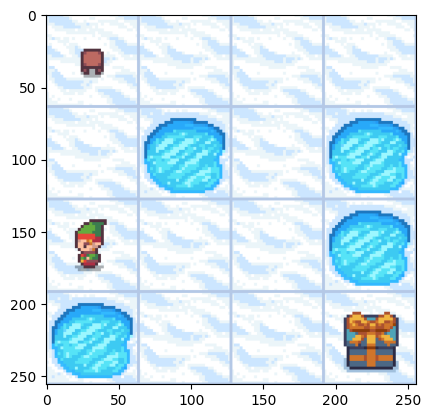

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

def visualize_agent(agent, env, num_episodes=5):
    for _ in range(num_episodes):
        observation = env.reset()
        done = False

        while not done:
            # Render the environment
            plt.imshow(env.render(mode='rgb_array')[0])  # Use [0] to remove the extra dimension
            display.display(plt.gcf())
            display.clear_output(wait=True)

            # Choose the action using epsilon-greedy strategy
            action = agent.choose_e_greedy_action(observation)

            # Take a step in the environment
            observation, _, done, _ = env.step(action)

    env.close()

# Assuming q_agent is your trained Q-learning agent and env is your FrozenLake environment
visualize_agent(q_agent, env)

# Appendix

## `np_array.max()`
Obtains the highest value on the array.

In [ ]:
test_array = np.array([0, 7, 3, 8, 4, 3, 9, 9, 2])
test_array.max()

9

## `np.flatnonzero(np_array)`

This method can be used to get the indices of the values in the array that are different from zero or zero-like (e.g. False).

In [ ]:
test_array = np.array([0, 7, 4, 0, 7, 5, 0, 3])
np.flatnonzero(test_array)

array([1, 2, 4, 5, 7])

In [ ]:
test_array = np.array([False, True, False, True, True, False])
np.flatnonzero(test_array)

array([1, 3, 4])

## `np.random.choice(np_array)`
Returns a random sample from the given array.

In [ ]:
test_array = np.array([4, 7, 11, 1, 8])
np.random.choice(test_array)

1

## `np.random.rand()`
Returns a random sample from 0 to 1.

In [ ]:
np.random.rand()

0.6826281989287277